In [159]:
from scipy.special import expit
import sys
import pandas as pd
import numpy as np

class MultiLayerPerceptronBase(object):
    def __init__(self, layers = 2, layer_width=[4, 3, 3], C = 0.1,
                 epochs = 500, eta = .001, activation="sigmoid", obj = "mse", random_state = None):
        np.random.seed(random_state)
        self.C = C
        self.epochs = epochs
        self.eta = eta
        self.layer_width = layer_width
        self.activation=activation
        self.obj = obj
        #add widths for input and output layers
#         self.layer_width.insert(0, 8)
        #output layer
#         self.layer_width.append(8)
        
        
        
    @staticmethod
    def _encode_labels(y):
        onehot = pd.get_dummies(y).values.T
        return onehot
    
    def _initialize_weights(self):
        self.weights = []
        for idx, w in enumerate(self.layer_width[:-1]):
            Wn_num_elements = (w + 1) * self.layer_width[idx+1]
            self.weights.append(np.random.uniform(-1.0, 1.0, size = Wn_num_elements).
                                reshape(self.layer_width[idx+1], w + 1))
        for w in self.weights:
            print(w.shape)
    
    @staticmethod
    def _sigmoid(z):
        return expit(z)
    
    @staticmethod
    def _relu(z):
        return np.maximum(0,z.copy())
    
    
    def _derive_activation(self, a_l, w_l, v_last, z_l):
        if self.activation == "sigmoid":
            return a_l * (1 - a_l) * (w_l.T @ v_last)
        if self.activation == "relu":
            print(a_l.shape)
            if a_l <= 0:
                return 0
            else: 
                return 1
    
    
    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
        
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        return X_new
    
    @staticmethod
    def _l2_reg(lambda_, weights):
        t = 0
        for w in weights:
            t += np.mean(w[:, 1:] **2)
        t = np.sqrt(t)
        t *= (lambda_/len(weights))
        return t
    def _cost(self, A_n, y_enc, weights):
        cost = np.mean((y_enc - A_n) **2)
        L2_term = self._l2_reg(self.C, weights)
        return cost + L2_term
    

In [151]:
class MultiLayerPerceptron(MultiLayerPerceptronBase):
    def _feedforward(self, X):
        A = []
        Z = []
        for idx, W_n in enumerate(self.weights):
            if len(Z) > 0:
                A_n = self._relu(Z[-1])
                A_n = self._add_bias_unit(A_n, how="row")
                Z_n = W_n @ A_n
                A.append(A_n)
                Z.append(Z_n)
            else:
                A_n = self._add_bias_unit(X, how="row")
                A_n = A_n
                Z_n = W_n @ A_n
                A.append(A_n)
                Z.append(Z_n)
        A.append(self._sigmoid(Z[-1]))
        return A, Z
    
    def _get_gradient(self, A, Z, Y_enc):
        gradients = []
        #gradient of objective function w/r to last activation
        gradients.append(np.zeros(self.weights[-1].shape))
        V2 = -2 * (Y_enc - A[-1]) * A[-1] * (1-A[-1])
        gradients[-1] = V2 @ A[-2].T
        V_last = V2
        
        for l in range(1, len(self.weights)):
            gradients.append(np.zeros(self.weights[len(self.weights) - l].shape))
            A_l = list(reversed(A))[l]
            W_l = list(reversed(self.weights))[l-1]
            if l == 1:
                V_l = self._derive_activation(A_l, W_l, V_last, Z[-1])
                V_last = V_l
            else:
                V_l = self._derive_activation(A_l, W_l, V_last, Z[-1])
                V_last = V_l
            gradients[-1] = V_l[1:, :] @ list(reversed(A))[l+1].T
    
            
        return list(reversed(gradients))
    def predict(self, X):
        A, Z = self._feedforward(X)
        a = A[-1]
        print(a)
        ypred = np.argmax(a, axis=0)
        return ypred
    def fit(self, X, y, print_progress=False):
        X_data, y_data = X.copy(), y.copy()
        Y_enc = self._encode_labels(y)
        self._initialize_weights()
        self.cost = []
        
        for i in range(self.epochs):
            if print_progress>0 and (i+1)%print_progress==0:
                sys.stderr.write('\rEpoch: %d/%d' % (i+1, self.epochs))
                sys.stderr.flush()
            
            A, Z = self._feedforward(X_data.reshape(self.layer_width[0], -1))
 
            cost = self._cost(A[-1], Y_enc, self.weights)
            self.cost.append(cost)
            grad = self._get_gradient(A,Z, Y_enc)
            for w, g in zip(self.weights, grad):
                g[:,1:] += w[:,1:] * self.C
                w -= self.eta*g
        print(self.cost)
        return self

In [152]:

# lets load up the handwritten digit dataset
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
import numpy as np

ds = load_digits()
X = ds.data/16.0-0.5
y = ds.target

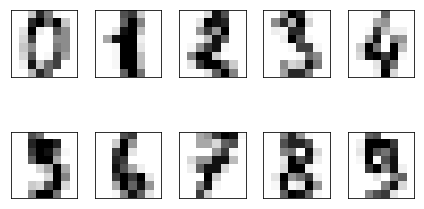

In [153]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

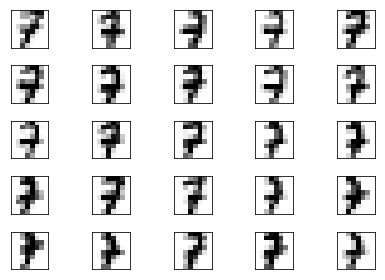

In [154]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
digit = 7
x_digits = X[y == digit]
for i in range(25):
    img = x_digits[i].reshape(8, 8)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [155]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.1)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1617, 64)
(1617,)
(180, 64)
(180,)


In [157]:

nn = MultiLayerPerceptron(2, [X_train.shape[1], 50, 10], 0.1, 500, 0.001, "relu")
nn.fit(X_train, y_train, print_progress=10)
yhat = nn.predict(X_test.T)
print(yhat)
print(y_test)
print('Test acc:',accuracy_score(y_test,yhat))

(50, 65)
(10, 51)
(51, 1617)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

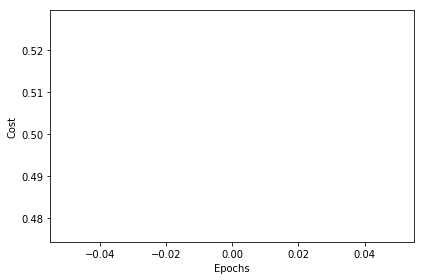

In [158]:
plt.plot(range(len(nn.cost)), nn.cost)
plt.ylabel('Cost')
plt.xlabel('Epochs')
plt.tight_layout()
plt.show()